# Kalman-Filter implementation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import multivariate_normal
from matplotlib.lines import Line2D

In [2]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
np.set_printoptions(suppress=True, precision=4)

custom_lines = [
    Line2D([0], [0], color="tab:blue", lw=2),
    Line2D([0], [0], color="tab:orange", lw=2)
]

In [3]:
# Taken orignally from https://github.com/probml/pyprobml
from matplotlib.patches import Ellipse, transforms
def plot_ellipse(Sigma, mu, ax, n_std=3.0, facecolor='none', edgecolor='k',  **kwargs):
    cov = Sigma
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, edgecolor=edgecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)

    ax.plot(mean_x, mean_y, '.', c="black")
    return ax.add_patch(ellipse)

### The goal: Recover the following parameters using a Kalman-Filter

In [428]:
def lds_sample(μ0, V0, A, C, Γ, Σ, n_sims, n_steps, T, noisy_init=True):
    """
    Simulation of a continous-time Kalman-Bucy filter using
    the Euler–Maruyama method
    """
    dt = T / n_steps
    m_latent, _ = A.shape
    m_obs, _ = C.shape
    # Sample initial condition
    N0 = multivariate_normal(np.zeros(m_latent), V0)
    z0 = μ0 + noisy_init * N0.rvs(n_sims)
    
    
    latent_rvs = multivariate_normal(cov=Γ).rvs((n_sims, n_steps))
    obs_rvs = multivariate_normal(cov=Σ).rvs((n_sims, n_steps))
    
    sol_latent = np.zeros((n_sims, n_steps, m_latent))
    sol_obs = np.zeros((n_sims, n_steps, m_obs))
    
    sol_latent[:, 0, :] = z0
    sol_obs[:, 0, :] = np.einsum("ij,sj->si", C, z0)
    
    zn = z0
    xn = np.einsum("ij,sj->si", C, z0) + obs_rvs[:, 0, :] * np.sqrt(dt)
    
    sol_latent[:, 0, :] = zn
    sol_obs[:, 0, :] = xn
    for n in range(1, n_steps):
        ϵn = latent_rvs[:, n, :]
        φn = obs_rvs[:, n, :]
        
        
        z_new = zn + np.einsum("ij,sj->si", A, zn) * dt + ϵn * np.sqrt(dt)
        xn = np.einsum("ij,sj->si", C, z_new) + φn * np.sqrt(dt)
        zn = z_new
        
        sol_latent[:, n, :] = zn
        sol_obs[:, n, :] = xn
        
    return sol_latent, sol_obs

In [429]:
μ0 = np.array([0, 0])
V0 = np.array([[1, 0], [0, 1]]) / 1000

A = np.array([
    [0, -1],
    [1, 0]
]) / 3

C = np.array([
    [1, -0.3],
    [0.3, 1]
]) 

# Γ = np.array([
#     [0.4,  -0.1],
#     [-0.1, 0.5]
# ])
# Γ = Γ @ Γ.T / 5


# high-variance configuration
Γ = np.eye(2) * 1.5
Σ = np.eye(2) * 5

# low-variance configuration
Γ = np.eye(2) * 1.2
Σ = np.eye(2) / 50

muv = np.zeros(4)
zeros = np.zeros((2, 2))

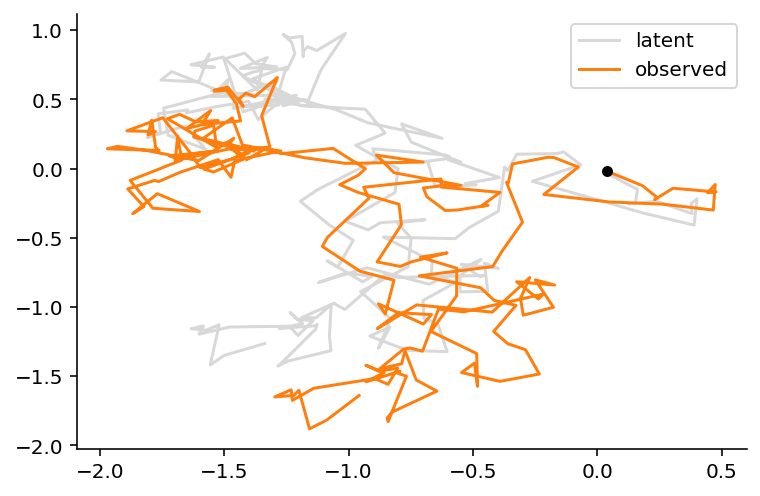

In [430]:
np.random.seed(314)
n_sims, n_steps = 5, 200
T = 2
latent, obs = lds_sample(μ0, V0, A, C, Γ, Σ, n_sims, n_steps, T)

nsim = 1
plt.scatter(*obs[nsim, 0], c="black", s=20, zorder=3)
plt.plot(*latent[nsim].T, label="latent", c="tab:gray", alpha=0.3)
plt.plot(*obs[nsim].T, label="observed", c="tab:orange")
plt.legend()

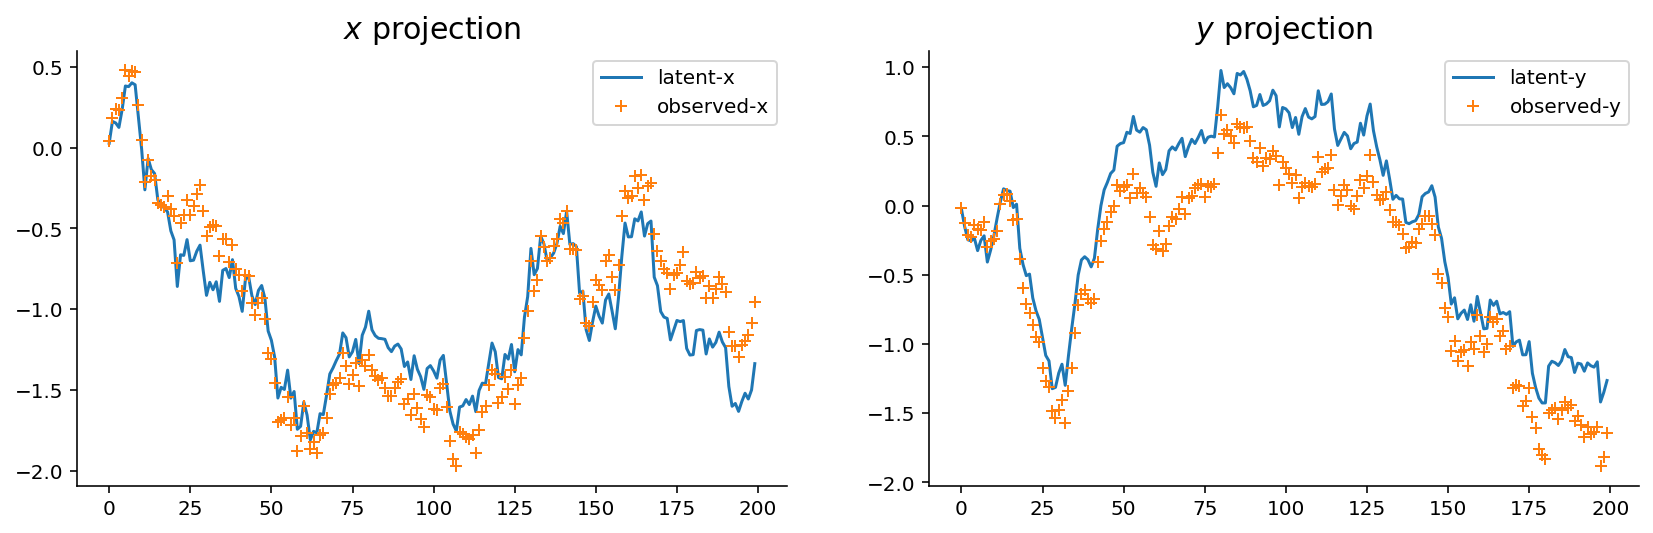

In [431]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(latent[nsim, :, 0], label="latent-x")
ax[0].plot(obs[nsim, :, 0], label="observed-x", marker="+", linewidth=0)
ax[0].legend()
ax[0].set_title("$x$ projection", fontsize=15)

ax[1].plot(latent[nsim, :, 1], label="latent-y")
ax[1].plot(obs[nsim, :, 1], label="observed-y", marker="+", linewidth=0)
ax[1].legend()
ax[1].set_title("$y$ projection", fontsize=15);

## Step 1: Suppose the parameters are already known

(-23.229513275773083,
 21.8990783484696,
 -25.492076185722286,
 29.374261103984423)

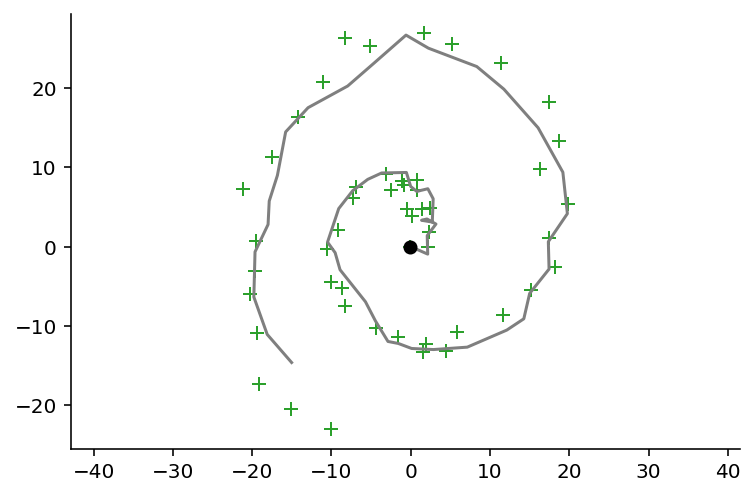

In [432]:
μ0 = np.array([0, 0])
V0 = np.array([[1, 0], [0, 1]]) / 1000

A = np.array([
    [-0, -1],
    [1, 0]
]) / 2

C = np.array([
    [1, -0.3],
    [0.5, 1]
]) 


# high-variance configuration
Γ = np.eye(2) * 2
Σ = np.eye(2) * 5

# low-variance configuration
Γ = np.eye(2) * 3
Σ = np.eye(2) * 0.8


muv = np.zeros(4)
zeros = np.zeros((2, 2))

np.random.seed(314)
n_sims, n_steps = 5, 50
T = 20
latent, obs = lds_sample(μ0, V0, A, C, Γ, Σ, n_sims, n_steps, T)

Z = latent[nsim]
X = obs[nsim]

plt.scatter(*X[0, :], c="black", zorder=2)
plt.plot(*X.T, c="tab:green", zorder=1, linewidth=0, marker="+", markersize=7)
plt.plot(*Z.T, c="tab:gray", zorder=1)
plt.axis("equal")

In [433]:

I = np.eye(2)
K1 = V0 @ C.T @ inv(C @ V0 @ C.T + Σ)

μ1 = μ0 + K1 @ (X[0] - C @ μ0)
V1 = (I - K1 @ C) @ V0

μ_hist = np.zeros((n_steps, 2))
V_hist = np.zeros((n_steps, 2, 2))

μ_update_hist = np.zeros((n_steps, 2))
P_hist = np.zeros((n_steps, 2, 2))


μ_hist[0] = μ1
V_hist[0] = V1
P_hist[0] = Γ
μ_update_hist[0] = μ0

Vn = V1
for n in range(1, n_steps):
    Pnm1 = Γ + A @ Vn @ A.T
    Sn = C @ Pnm1 @ C.T + Σ
    Kn = Pnm1 @ C.T @ inv(Sn)
    
    μ_update = A @ μ_hist[n-1]
    x_update = C @ μ_update
    
    μn = μ_update + Kn @ (X[n] - x_update)
    Vn = (I - Kn @ C) @ Pnm1
    
    μ_hist[n] = μn
    V_hist[n] = Vn
    μ_update_hist[n] = μ_update
    P_hist[n] = Pnm1

Text(0.5, 1.0, 'y projection')

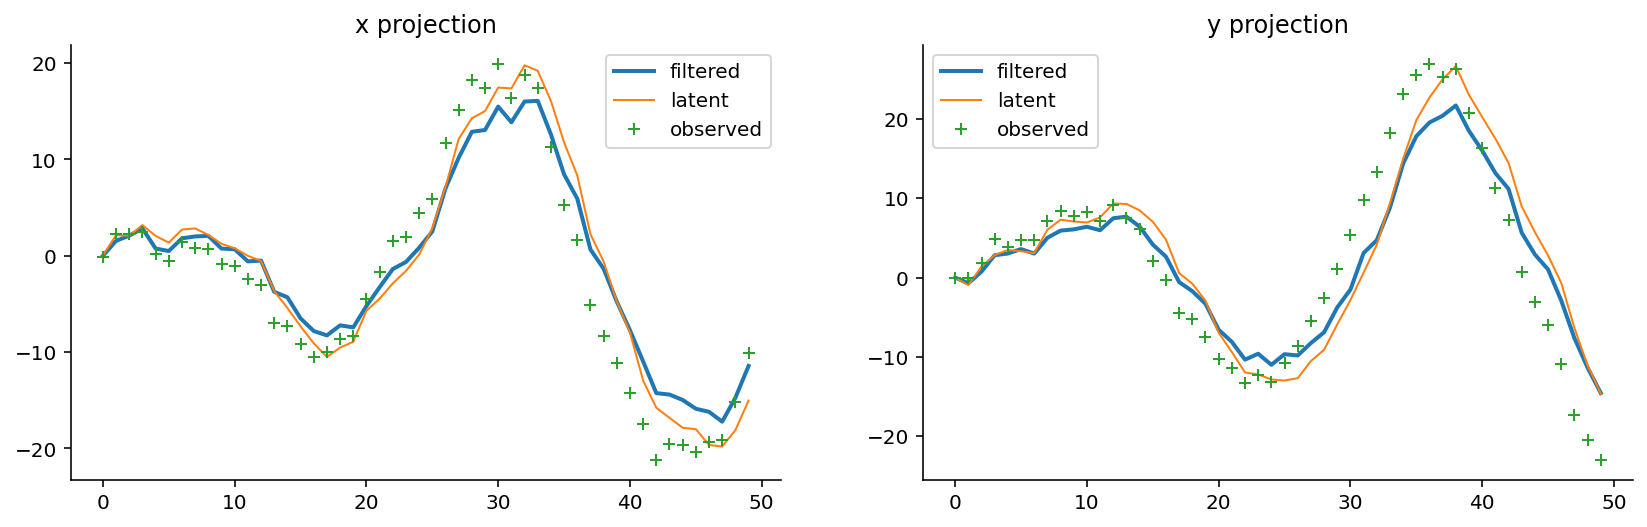

In [434]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(μ_hist[:, 0], label="filtered", linewidth=2)
ax[0].plot(Z[:, 0], label="latent", linewidth=1)
ax[0].plot(X[:, 0], label="observed", linewidth=0, marker="+")
ax[0].legend()
ax[0].set_title("x projection")

ax[1].plot(μ_hist[:, 1], label="filtered", linewidth=2)
ax[1].plot(Z[:, 1], label="latent", linewidth=1)
ax[1].plot(X[:, 1], label="observed", linewidth=0, marker="+")
ax[1].legend()
ax[1].set_title("y projection")

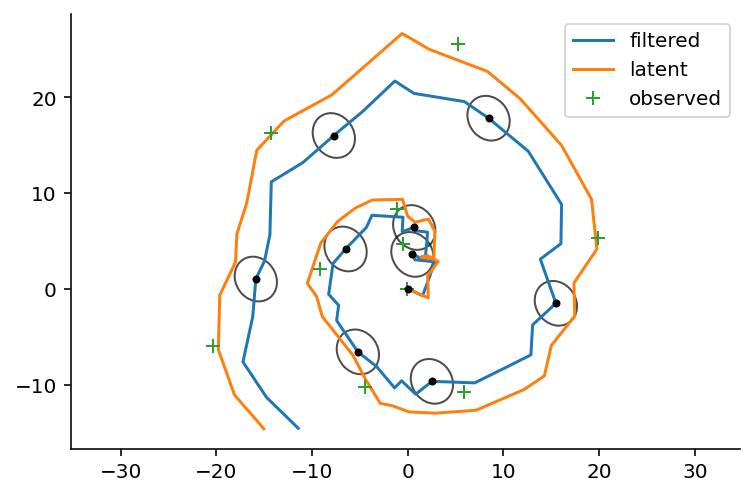

In [435]:
fig, ax = plt.subplots()

ax.plot(*μ_hist.T, label="filtered")
ax.plot(*Z.T, label="latent")
ax.plot(*X[::5].T, markersize=7, linewidth=0, marker="+", label="observed")

for μn, Vn in zip(μ_hist[::5], V_hist[::5]):
    plot_ellipse(Vn, μn, ax, n_std=3, alpha=0.7)

plt.legend()
plt.axis("equal");

### Smoothing the observations

In [436]:
timesteps, _ = μ_hist.shape
state_size, _ = A.shape


μhat_hist = np.zeros((timesteps, state_size))
Vhat_hist = np.zeros((timesteps, state_size, state_size))

μhat_n = μ_hist[-1, :]
Vhat_n = V_hist[-1, ...]

μhat_hist[-1, :] = μhat_n
Vhat_hist[-1, ...] = Vhat_n

elements = zip(μ_hist[-2::-1], V_hist[-2::-1, ...], μ_update_hist[::-1], P_hist[-2::-1, ...])
for n, (μn, Vn, μ_update_n, Pn) in enumerate(elements, 1):
    Jn = Vn @ A.T @ inv(Pn)
    μhat_n = μn + Jn @ (μhat_n - A @ μn)
    Vhat_n = Vn + Jn @ (Vhat_n - Pn) @ Jn.T
    
    μhat_hist[-(n+1)] = μhat_n
    Vhat_hist[-(n+1)] = Vhat_n

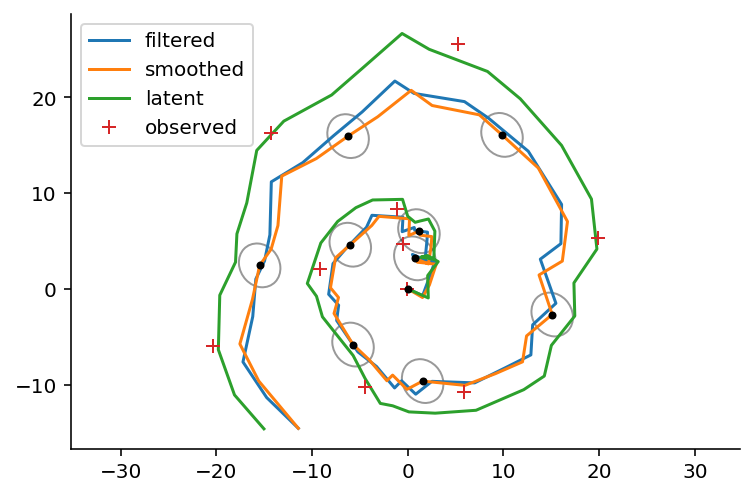

In [437]:
fig, ax = plt.subplots()

ax.plot(*μ_hist.T, label="filtered")
plt.plot(*μhat_hist.T, label="smoothed")
ax.plot(*Z.T, label="latent")
ax.plot(*X[::5].T, markersize=7, linewidth=0, marker="+", label="observed")


for μn, Vn in zip(μhat_hist[::5], Vhat_hist[::5]):
    plot_ellipse(Vn, μn, ax, n_std=3, alpha=0.4)

plt.legend()
plt.axis("equal");

## Example 2

In [438]:
def lds_sample(μ0, V0, A, C, Γ, Σ, n_sims, n_steps, T, noisy_init=True):
    """
    Simulation of a continous-time Kalman-Bucy filter using
    the Euler–Maruyama method
    """
    dt = T / n_steps
    m_latent, _ = A.shape
    m_obs, _ = C.shape
    # Sample initial condition
    N0 = multivariate_normal(np.zeros(m_latent), V0)
    if noisy_init:
        z0 = μ0 + noisy_init * N0.rvs(n_sims)
    else:
        z0 = μ0 * np.ones((n_sims, m_latent))
    
    
    latent_rvs = multivariate_normal(cov=Γ).rvs((n_sims, n_steps))
    obs_rvs = multivariate_normal(cov=Σ).rvs((n_sims, n_steps))
    
    sol_latent = np.zeros((n_sims, n_steps, m_latent))
    sol_obs = np.zeros((n_sims, n_steps, m_obs))
    
    sol_latent[:, 0, :] = z0
    sol_obs[:, 0, :] = np.einsum("ij,sj->si", C, z0)
    
    zn = z0
    xn = np.einsum("ij,sj->si", C, z0)
    
    sol_latent[:, 0, :] = zn
    sol_obs[:, 0, :] = xn
    for n in range(1, n_steps):
        ϵn = latent_rvs[:, n, :]
        φn = obs_rvs[:, n, :]
        
        
        z_new = np.einsum("ij,sj->si", A, zn) * dt + ϵn * np.sqrt(dt)
        xn = np.einsum("ij,sj->si", C, z_new) + φn * np.sqrt(dt)
        zn = z_new
        
        sol_latent[:, n, :] = zn
        sol_obs[:, n, :] = xn
        
    return sol_latent, sol_obs

In [439]:
Δx, Δy = 1, 1
A = np.array([
    [1, 0, Δx, 0],
    [0, 1, 0, Δy],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

Γ = np.eye(4) * 0.001
Σ = np.eye(2) * 1.0

μ0 = np.array([8, 10, 1, 0])
V0 = np.eye(4) * 1.0

n_sims, n_steps = 4, 15
nsim = 0
T = 15

In [440]:
np.random.seed(3141)
latent, obs = lds_sample(μ0, V0, A, C, Γ, Σ, n_sims, n_steps, T, noisy_init=True)

Z = latent[nsim]
X = obs[nsim]

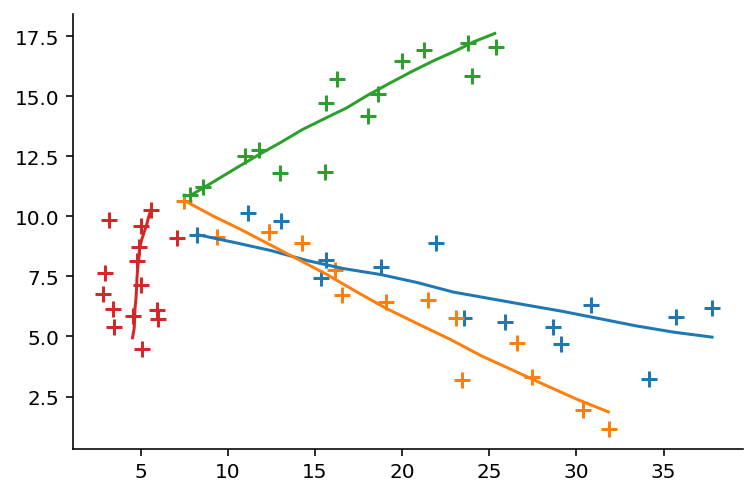

In [441]:
for nsim in range(n_sims):
    Z = latent[nsim]
    X = obs[nsim]
    plt.plot(*Z[:, :2].T)
    plt.scatter(*X.T, marker="+", s=60)

In [419]:
I = np.eye(4)
K1 = V0 @ C.T @ inv(C @ V0 @ C.T + Σ)

μ1 = μ0 + K1 @ (X[0] - C @ μ0)
V1 = (I - K1 @ C) @ V0

μ_hist = np.zeros((n_steps, 4))
V_hist = np.zeros((n_steps, 4, 4))
μ_hist[0] = μ1
V_hist[0] = V1

Vn = V1
for n in range(1, n_steps):
    Pnm1 = A @ Vn @ A.T + Γ
    Sn = C @ Pnm1 @ C.T + Σ
    Kn = Pnm1 @ C.T @ inv(Sn)
    
    μ_update = A @ μ_hist[n-1]
    x_update = C @ μ_update
    μn = μ_update + Kn @ (X[n] - x_update)
    Vn = (I - Kn @ C) @ Pnm1
    
    μ_hist[n] = μn
    V_hist[n] = Vn

In [420]:
μ_hist

array([[ 6.7904, 10.1274,  1.    ,  0.    ],
       [ 6.113 ,  9.8029, -0.1175, -0.2162],
       [ 4.1186,  9.7678, -1.056 , -0.1257],
       [ 4.2056,  9.0896, -0.6269, -0.3331],
       [ 5.4997,  8.946 , -0.0528, -0.2765],
       [ 5.1216,  8.4171, -0.1337, -0.3393],
       [ 5.0068,  7.6701, -0.1297, -0.4265],
       [ 5.3075,  6.7925, -0.0485, -0.5116],
       [ 4.3911,  6.452 , -0.1961, -0.4825],
       [ 4.7959,  5.8946, -0.1023, -0.4942],
       [ 4.1506,  6.1034, -0.1813, -0.3918],
       [ 3.8128,  5.8381, -0.2029, -0.3744],
       [ 3.8776,  5.5767, -0.1676, -0.3595],
       [ 3.6506,  5.2672, -0.1752, -0.3531],
       [ 3.8842,  4.7976, -0.1239, -0.3677]])

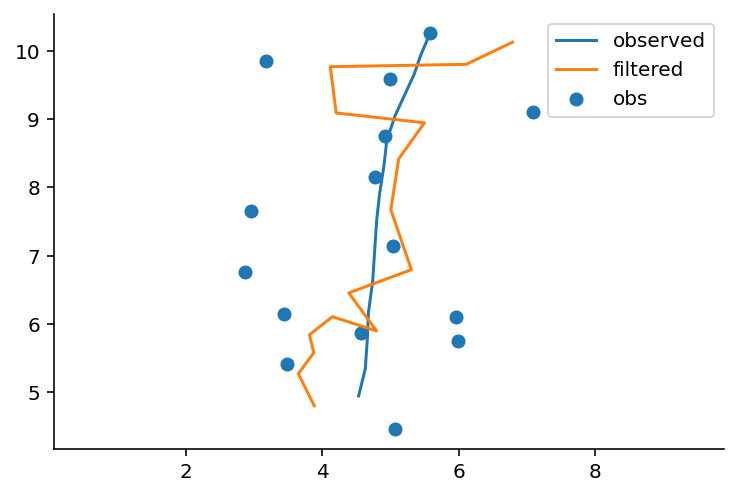

In [421]:
plt.scatter(*obs[nsim].T, label="obs")
plt.plot(*latent[nsim][:, :2].T, label="observed")
plt.plot(*μ_hist[:, :2].T, label="filtered")
plt.axis("equal")
plt.legend()